# NOTEBOOK 1: DATA PREPARATION & STRATIFIED SPLITS

## HMDB51 Fight Dataset - Violence Detection

**Project Goal**: Achieve 87-90% accuracy on HMDB51 Fight (8 classes, ~75,900 images)  
**Current Baseline**: VGG-16 with 71% accuracy  
**Hardware**: 8× NVIDIA H200 GPUs

**This Notebook**:

1. Load HMDB51 Fight dataset from `./fight_dataset/actions (2)/actions`
2. Analyze class distribution
3. Create stratified 70/15/15 train/val/test splits
4. Save splits to `./novelty_files/splits/` (resume-safe)
5. Visualize sample images

**Expected Runtime**: ~5 minutes  
**Outputs**: Train/val/test indices, class distribution JSON, sample images


## CELL 1: Environment Setup & Imports

All required libraries for data loading, preprocessing, and visualization.


In [1]:
# ============================================================
# CELL 1: ENVIRONMENT SETUP & IMPORTS
# ============================================================

"""
This cell imports all required libraries for:
- PyTorch and deep learning utilities
- Data loading and preprocessing
- Stratified splitting
- Visualization
- File I/O and path management
"""

import os
import sys
import json
import random
import pickle
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

# Vision
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image

# Data processing
import numpy as np
import pandas as pd

# Stratified splitting
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("="*80)
print("VIOLENCE DETECTION - NOVELTY IMPLEMENTATION")
print("Notebook 1: Data Preparation & Stratified Splits")
print("="*80)
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        props = torch.cuda.get_device_properties(i)
        print(f"  GPU {i}: {props.name} - {props.total_memory / 1e9:.1f}GB")

print(f"\nPython Version: {sys.version.split()[0]}")
print(f"NumPy Version: {np.__version__}")
print("="*80)

# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"\n✓ Random seeds set to {RANDOM_SEED} for reproducibility")
print("✓ All imports successful")

VIOLENCE DETECTION - NOVELTY IMPLEMENTATION
Notebook 1: Data Preparation & Stratified Splits
PyTorch Version: 2.9.1+cu128
CUDA Available: True
Number of GPUs: 8
  GPU 0: NVIDIA H200 - 150.1GB
  GPU 1: NVIDIA H200 - 150.1GB
  GPU 2: NVIDIA H200 - 150.1GB
  GPU 3: NVIDIA H200 - 150.1GB
  GPU 4: NVIDIA H200 - 150.1GB
  GPU 5: NVIDIA H200 - 150.1GB
  GPU 6: NVIDIA H200 - 150.1GB
  GPU 7: NVIDIA H200 - 150.1GB

Python Version: 3.10.19
NumPy Version: 2.2.6

✓ Random seeds set to 42 for reproducibility
✓ All imports successful


## CELL 2: Global Configuration & Directory Structure

Define all paths and create the `novelty_files/` directory structure.


In [2]:
# ============================================================
# CELL 2: GLOBAL CONFIGURATION & DIRECTORY STRUCTURE
# ============================================================

"""
This cell:
1. Defines all project paths and configurations
2. Creates the novelty_files/ directory structure
3. Sets up image processing parameters
4. Defines dataset split ratios

CRITICAL: All outputs must go to novelty_files/ subdirectories
"""

# ============================================================
# PROJECT CONFIGURATION
# ============================================================

CONFIG = {
    # Dataset paths
    'dataset_path': './fight_dataset/actions (2)/actions',  # HMDB51 Fight dataset location
    'base_dir': Path('./novelty_files'),  # All outputs go here
    
    # Image processing
    'image_size': 224,  # Standard size for ViT-Base (224×224)
    'imagenet_mean': [0.485, 0.456, 0.406],  # ImageNet normalization
    'imagenet_std': [0.229, 0.224, 0.225],
    
    # Dataset split ratios (from paper specification)
    'train_ratio': 0.70,  # 70% for training
    'val_ratio': 0.15,    # 15% for validation
    'test_ratio': 0.15,   # 15% for testing (unseen until final evaluation)
    
    # Classes (HMDB51 Fight - 8 action classes)
    'classes': {
        0: 'hit', 
        1: 'kick', 
        2: 'punch', 
        3: 'push',
        4: 'ride_horse', 
        5: 'shoot_gun', 
        6: 'stand', 
        7: 'wave'
    },
    'num_classes': 8,
    
    # Violence categorization (for binary classification analysis)
    'violence_classes': ['hit', 'kick', 'punch', 'shoot_gun'],
    'non_violence_classes': ['push', 'ride_horse', 'stand', 'wave'],
    
    # Reproducibility
    'random_seed': 42,
}

# ============================================================
# CREATE DIRECTORY STRUCTURE
# ============================================================

"""
Directory structure (as per project specification):

novelty_files/
├── configs/          # Hyperparameters for reproducibility
├── splits/           # Train/val/test indices (resume-safe)
├── features/         # Extracted features for NSL
├── graphs/           # Graph structures for regularization
├── checkpoints/      # Model weights (best model, adversarial, etc.)
├── logs/             # Training logs & curves
├── metrics/          # Final results JSON, ablation CSV
└── visualizations/   # Publication-ready figures
    └── grad_cam/     # Interpretability visualizations
"""

base_dir = CONFIG['base_dir']
subdirs = [
    'configs',
    'splits',
    'features',
    'graphs',
    'checkpoints',
    'logs',
    'metrics',
    'visualizations',
    'visualizations/grad_cam',
]

print("\n" + "="*80)
print("CREATING DIRECTORY STRUCTURE")
print("="*80)

for subdir in subdirs:
    dir_path = base_dir / subdir
    dir_path.mkdir(parents=True, exist_ok=True)
    print(f"✓ Created: {dir_path}")

print("="*80)

# ============================================================
# SAVE CONFIGURATION
# ============================================================

config_path = base_dir / 'configs' / 'notebook_01_config.json'

# Convert Path objects to strings for JSON serialization
config_to_save = CONFIG.copy()
config_to_save['base_dir'] = str(CONFIG['base_dir'])

with open(config_path, 'w') as f:
    json.dump(config_to_save, f, indent=2)

print(f"\n✓ Configuration saved to: {config_path}")

# ============================================================
# DISPLAY CONFIGURATION SUMMARY
# ============================================================

print("\n" + "="*80)
print("CONFIGURATION SUMMARY")
print("="*80)
print(f"Dataset Path: {CONFIG['dataset_path']}")
print(f"Output Directory: {CONFIG['base_dir']}")
print(f"Image Size: {CONFIG['image_size']}×{CONFIG['image_size']}")
print(f"Number of Classes: {CONFIG['num_classes']}")
print(f"Classes: {list(CONFIG['classes'].values())}")
print(f"\nSplit Ratios:")
print(f"  Train: {CONFIG['train_ratio']:.0%}")
print(f"  Val:   {CONFIG['val_ratio']:.0%}")
print(f"  Test:  {CONFIG['test_ratio']:.0%}")
print("="*80)


CREATING DIRECTORY STRUCTURE
✓ Created: novelty_files/configs
✓ Created: novelty_files/splits
✓ Created: novelty_files/features
✓ Created: novelty_files/graphs
✓ Created: novelty_files/checkpoints
✓ Created: novelty_files/logs
✓ Created: novelty_files/metrics
✓ Created: novelty_files/visualizations
✓ Created: novelty_files/visualizations/grad_cam

✓ Configuration saved to: novelty_files/configs/notebook_01_config.json

CONFIGURATION SUMMARY
Dataset Path: ./fight_dataset/actions (2)/actions
Output Directory: novelty_files
Image Size: 224×224
Number of Classes: 8
Classes: ['hit', 'kick', 'punch', 'push', 'ride_horse', 'shoot_gun', 'stand', 'wave']

Split Ratios:
  Train: 70%
  Val:   15%
  Test:  15%


## CELL 3: Load Dataset & Analyze Class Distribution

Load HMDB51 Fight dataset and analyze the distribution of samples across all 8 classes.


In [3]:
# ============================================================
# CELL 3: LOAD DATASET & ANALYZE CLASS DISTRIBUTION
# ============================================================

"""
This cell:
1. Loads the HMDB51 Fight dataset from train/ and test/ folders
2. Combines them into a single dataset (we'll create custom splits)
3. Analyzes class distribution
4. Saves dataset statistics

The dataset has pre-existing train/test splits, but we'll create our own
stratified 70/15/15 splits in the next cell for better control.
"""

# ============================================================
# DEFINE SIMPLE DATASET CLASS
# ============================================================

class HMDB51FightDataset(Dataset):
    """
    Custom dataset for HMDB51 Fight images.
    
    This dataset:
    - Loads images from the directory structure
    - Returns (image_path, label, class_name) tuples
    - Does NOT apply transforms yet (we'll do that when creating DataLoaders)
    
    Args:
        root_dir: Path to dataset root (contains train/ and test/)
        split: 'train' or 'test' (to load from existing folders)
        class_to_idx: Dictionary mapping class names to indices
    """
    
    def __init__(self, root_dir: str, split: str, class_to_idx: Dict[str, int]):
        self.root_dir = Path(root_dir)
        self.split = split
        self.class_to_idx = class_to_idx
        self.idx_to_class = {v: k for k, v in class_to_idx.items()}
        
        # Load all image paths and labels
        self.samples = []
        split_dir = self.root_dir / split
        
        if not split_dir.exists():
            raise ValueError(f"Split directory does not exist: {split_dir}")
        
        # Iterate through each class folder
        for class_name, class_idx in class_to_idx.items():
            class_dir = split_dir / class_name
            
            if class_dir.exists():
                # Find all image files (jpg and png)
                image_files = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
                
                for img_path in image_files:
                    self.samples.append({
                        'path': str(img_path),
                        'label': class_idx,
                        'class_name': class_name
                    })
    
    def __len__(self) -> int:
        return len(self.samples)
    
    def __getitem__(self, idx: int) -> Tuple[str, int, str]:
        """Returns (image_path, label, class_name)"""
        sample = self.samples[idx]
        return sample['path'], sample['label'], sample['class_name']

# ============================================================
# LOAD DATASET
# ============================================================

print("\n" + "="*80)
print("LOADING HMDB51 FIGHT DATASET")
print("="*80)

dataset_path = CONFIG['dataset_path']
print(f"Dataset location: {dataset_path}")

# Check if dataset exists
if not Path(dataset_path).exists():
    raise FileNotFoundError(
        f"Dataset not found at {dataset_path}\n"
        f"Please ensure the HMDB51 Fight dataset is downloaded and extracted to this location."
    )

# Create class_to_idx mapping (alphabetical order to match ImageFolder convention)
class_names_sorted = sorted(CONFIG['classes'].values())
class_to_idx = {name: idx for idx, name in enumerate(class_names_sorted)}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

print(f"\nClass to Index Mapping:")
for class_name, idx in sorted(class_to_idx.items(), key=lambda x: x[1]):
    print(f"  {idx}: {class_name}")

# Load train and test splits separately
print(f"\nLoading existing train/ and test/ folders...")
train_dataset = HMDB51FightDataset(dataset_path, 'train', class_to_idx)
test_dataset = HMDB51FightDataset(dataset_path, 'test', class_to_idx)

print(f"✓ Loaded {len(train_dataset)} images from train/")
print(f"✓ Loaded {len(test_dataset)} images from test/")

# Combine into a single dataset (we'll create our own splits)
all_samples = train_dataset.samples + test_dataset.samples
total_images = len(all_samples)

print(f"\n✓ Total images: {total_images}")

# ============================================================
# ANALYZE CLASS DISTRIBUTION
# ============================================================

print("\n" + "="*80)
print("CLASS DISTRIBUTION ANALYSIS")
print("="*80)

# Count samples per class
class_counts = Counter([sample['label'] for sample in all_samples])
class_distribution = {}

for label in sorted(class_counts.keys()):
    class_name = idx_to_class[label]
    count = class_counts[label]
    percentage = 100 * count / total_images
    class_distribution[class_name] = count
    print(f"{label}: {class_name:15s} - {count:6d} images ({percentage:5.2f}%)")

print(f"\nTotal: {total_images} images")

# Check for class imbalance
max_count = max(class_counts.values())
min_count = min(class_counts.values())
imbalance_ratio = max_count / min_count

print(f"\nClass Balance Analysis:")
print(f"  Max samples per class: {max_count}")
print(f"  Min samples per class: {min_count}")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}x")

if imbalance_ratio > 2.0:
    print(f"  ⚠ WARNING: Significant class imbalance detected!")
    print(f"     Consider using class weights in loss function.")
else:
    print(f"  ✓ Classes are reasonably balanced")

print("="*80)

# ============================================================
# SAVE CLASS DISTRIBUTION
# ============================================================

distribution_data = {
    'total_images': total_images,
    'num_classes': len(class_to_idx),
    'class_distribution': class_distribution,
    'class_to_idx': class_to_idx,
    'idx_to_class': idx_to_class,
    'imbalance_ratio': float(imbalance_ratio),
}

distribution_path = base_dir / 'splits' / 'class_distribution.json'
with open(distribution_path, 'w') as f:
    json.dump(distribution_data, f, indent=2)

print(f"\n✓ Class distribution saved to: {distribution_path}")

# Store in CONFIG for use in later cells
CONFIG['class_to_idx'] = class_to_idx
CONFIG['idx_to_class'] = idx_to_class
CONFIG['all_samples'] = all_samples
CONFIG['total_images'] = total_images


LOADING HMDB51 FIGHT DATASET
Dataset location: ./fight_dataset/actions (2)/actions

Class to Index Mapping:
  0: hit
  1: kick
  2: punch
  3: push
  4: ride_horse
  5: shoot_gun
  6: stand
  7: wave

Loading existing train/ and test/ folders...
✓ Loaded 68048 images from train/
✓ Loaded 7807 images from test/

✓ Total images: 75855

CLASS DISTRIBUTION ANALYSIS
0: hit             -   4133 images ( 5.45%)
1: kick            -   5950 images ( 7.84%)
2: punch           -   8921 images (11.76%)
3: push            -  10335 images (13.62%)
4: ride_horse      -  16971 images (22.37%)
5: shoot_gun       -   9832 images (12.96%)
6: stand           -  11259 images (14.84%)
7: wave            -   8454 images (11.14%)

Total: 75855 images

Class Balance Analysis:
  Max samples per class: 16971
  Min samples per class: 4133
  Imbalance ratio: 4.11x
  ⚠ WARNING: Significant class imbalance detected!
     Consider using class weights in loss function.

✓ Class distribution saved to: novelty_files/sp

## CELL 4: Create Stratified Train/Val/Test Splits (RESUME-SAFE)

Create 70/15/15 stratified splits ensuring equal class distribution across all splits.  
**CRITICAL**: This cell checks if splits already exist and skips recomputation if found.


In [4]:
# ============================================================
# CELL 4: CREATE STRATIFIED SPLITS (RESUME-SAFE)
# ============================================================

"""
This cell creates stratified train/val/test splits with 70/15/15 ratio.

RESUME-SAFE PATTERN:
1. Check if split files already exist
2. If yes → load and skip computation
3. If no → create splits and save

This ensures we can restart the notebook without losing previous work.
"""

# ============================================================
# CHECK IF SPLITS ALREADY EXIST (RESUME-SAFE)
# ============================================================

splits_dir = base_dir / 'splits'
train_indices_path = splits_dir / 'train_indices.pkl'
val_indices_path = splits_dir / 'val_indices.pkl'
test_indices_path = splits_dir / 'test_indices.pkl'

if train_indices_path.exists() and val_indices_path.exists() and test_indices_path.exists():
    print("\n" + "="*80)
    print("LOADING EXISTING SPLITS (RESUME-SAFE)")
    print("="*80)
    print("✓ Found existing split files, loading instead of recomputing...")
    
    with open(train_indices_path, 'rb') as f:
        train_indices = pickle.load(f)
    with open(val_indices_path, 'rb') as f:
        val_indices = pickle.load(f)
    with open(test_indices_path, 'rb') as f:
        test_indices = pickle.load(f)
    
    print(f"✓ Loaded train indices: {len(train_indices)} samples")
    print(f"✓ Loaded val indices: {len(val_indices)} samples")
    print(f"✓ Loaded test indices: {len(test_indices)} samples")
    print("="*80)

else:
    print("\n" + "="*80)
    print("CREATING STRATIFIED SPLITS")
    print("="*80)
    print("No existing splits found. Creating new stratified splits...")
    
    # ============================================================
    # PREPARE DATA FOR STRATIFICATION
    # ============================================================
    
    # Extract all labels for stratification
    all_labels = np.array([sample['label'] for sample in all_samples])
    all_indices = np.arange(len(all_samples))
    
    print(f"\nTotal samples: {len(all_samples)}")
    print(f"Split ratios: Train={CONFIG['train_ratio']:.0%}, Val={CONFIG['val_ratio']:.0%}, Test={CONFIG['test_ratio']:.0%}")
    
    # ============================================================
    # STEP 1: Split into train+val (85%) and test (15%)
    # ============================================================
    
    # First split: separate test set (15%)
    trainval_indices, test_indices, trainval_labels, test_labels = train_test_split(
        all_indices,
        all_labels,
        test_size=CONFIG['test_ratio'],
        stratify=all_labels,
        random_state=RANDOM_SEED
    )
    
    print(f"\n✓ Step 1: Split into train+val and test")
    print(f"  Train+Val: {len(trainval_indices)} samples")
    print(f"  Test:      {len(test_indices)} samples ({len(test_indices)/len(all_samples):.1%})")
    
    # ============================================================
    # STEP 2: Split train+val into train (70%) and val (15%)
    # ============================================================
    
    # Calculate val size relative to train+val
    # We want: train=70%, val=15% of total
    # So val should be: 15% / (70% + 15%) = 15/85 ≈ 0.176 of train+val
    val_size_ratio = CONFIG['val_ratio'] / (CONFIG['train_ratio'] + CONFIG['val_ratio'])
    
    train_indices, val_indices, train_labels, val_labels = train_test_split(
        trainval_indices,
        trainval_labels,
        test_size=val_size_ratio,
        stratify=trainval_labels,
        random_state=RANDOM_SEED
    )
    
    print(f"\n✓ Step 2: Split train+val into train and val")
    print(f"  Train: {len(train_indices)} samples ({len(train_indices)/len(all_samples):.1%})")
    print(f"  Val:   {len(val_indices)} samples ({len(val_indices)/len(all_samples):.1%})")
    
    # ============================================================
    # VERIFY STRATIFICATION
    # ============================================================
    
    print("\n" + "-"*80)
    print("VERIFYING STRATIFICATION")
    print("-"*80)
    
    def verify_stratification(indices, split_name):
        """Verify that class distribution matches overall distribution"""
        split_labels = [all_samples[i]['label'] for i in indices]
        split_counts = Counter(split_labels)
        
        print(f"\n{split_name} Split ({len(indices)} samples):")
        print(f"  Class distribution:")
        
        for label in sorted(split_counts.keys()):
            class_name = idx_to_class[label]
            count = split_counts[label]
            percentage = 100 * count / len(indices)
            print(f"    {label}: {class_name:15s} - {count:5d} ({percentage:5.2f}%)")
        
        return split_counts
    
    train_counts = verify_stratification(train_indices, "Train")
    val_counts = verify_stratification(val_indices, "Validation")
    test_counts = verify_stratification(test_indices, "Test")
    
    # ============================================================
    # SAVE SPLITS
    # ============================================================
    
    print("\n" + "-"*80)
    print("SAVING SPLITS")
    print("-"*80)
    
    with open(train_indices_path, 'wb') as f:
        pickle.dump(train_indices, f)
    print(f"✓ Saved train indices to: {train_indices_path}")
    
    with open(val_indices_path, 'wb') as f:
        pickle.dump(val_indices, f)
    print(f"✓ Saved val indices to: {val_indices_path}")
    
    with open(test_indices_path, 'wb') as f:
        pickle.dump(test_indices, f)
    print(f"✓ Saved test indices to: {test_indices_path}")
    
    print("="*80)

# ============================================================
# FINAL VERIFICATION
# ============================================================

print("\n" + "="*80)
print("SPLIT SUMMARY")
print("="*80)
print(f"Train: {len(train_indices):6d} samples ({len(train_indices)/len(all_samples):.1%})")
print(f"Val:   {len(val_indices):6d} samples ({len(val_indices)/len(all_samples):.1%})")
print(f"Test:  {len(test_indices):6d} samples ({len(test_indices)/len(all_samples):.1%})")
print(f"Total: {len(all_samples):6d} samples")
print("="*80)

# Verify no overlap
assert len(set(train_indices) & set(val_indices)) == 0, "ERROR: Train and val sets overlap!"
assert len(set(train_indices) & set(test_indices)) == 0, "ERROR: Train and test sets overlap!"
assert len(set(val_indices) & set(test_indices)) == 0, "ERROR: Val and test sets overlap!"
print("\n✓ Verified: No overlap between splits")

# Store in CONFIG for use in later cells
CONFIG['train_indices'] = train_indices
CONFIG['val_indices'] = val_indices
CONFIG['test_indices'] = test_indices

print("✓ Splits stored in CONFIG for use in subsequent notebooks")


LOADING EXISTING SPLITS (RESUME-SAFE)
✓ Found existing split files, loading instead of recomputing...
✓ Loaded train indices: 53097 samples
✓ Loaded val indices: 11379 samples
✓ Loaded test indices: 11379 samples

SPLIT SUMMARY
Train:  53097 samples (70.0%)
Val:    11379 samples (15.0%)
Test:   11379 samples (15.0%)
Total:  75855 samples

✓ Verified: No overlap between splits
✓ Splits stored in CONFIG for use in subsequent notebooks


## CELL 5: Visualize Sample Images from Each Class

Display sample images from the training set to verify data loading and get a visual understanding of the dataset.



VISUALIZING SAMPLE IMAGES
✓ Selected 8 sample images (1 per class)


✓ Visualization saved to: novelty_files/visualizations/sample_images_per_class.png


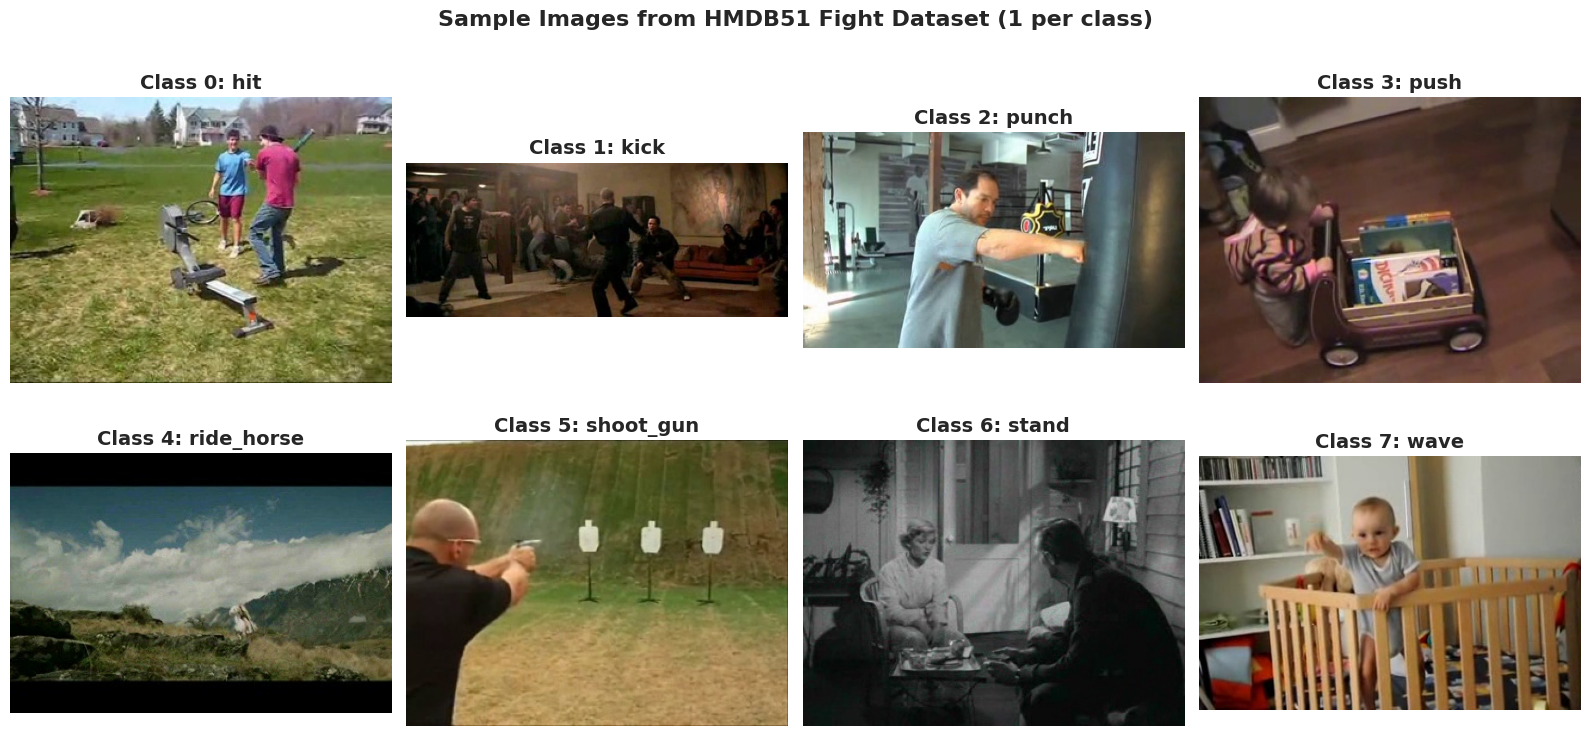


SAMPLE IMAGE DETAILS
0: hit             - 320×240 - hit1718.jpg
1: kick            - 592×240 - kick1353.jpg
2: punch           - 424×240 - punch4765.jpg
3: push            - 320×240 - push4414.jpg
4: ride_horse      - 352×240 - ridehorse15034.jpg
5: shoot_gun       - 320×240 - shootgun3885.jpg
6: stand           - 320×240 - stand265.jpg
7: wave            - 360×240 - wave4228.jpg


In [5]:
# ============================================================
# CELL 5: VISUALIZE SAMPLE IMAGES
# ============================================================

"""
This cell:
1. Selects random sample images from each class
2. Displays them in a grid (2 rows × 4 columns = 8 classes)
3. Saves the visualization for documentation
"""

print("\n" + "="*80)
print("VISUALIZING SAMPLE IMAGES")
print("="*80)

# ============================================================
# SELECT SAMPLE IMAGES (1 per class from training set)
# ============================================================

# Group training samples by class
class_samples = {i: [] for i in range(CONFIG['num_classes'])}

for idx in train_indices:
    sample = all_samples[idx]
    label = sample['label']
    class_samples[label].append(sample)

# Select one random sample per class
np.random.seed(RANDOM_SEED)  # For reproducibility
selected_samples = []

for label in sorted(class_samples.keys()):
    samples = class_samples[label]
    random_idx = np.random.randint(0, len(samples))
    selected_samples.append(samples[random_idx])

print(f"✓ Selected {len(selected_samples)} sample images (1 per class)")

# ============================================================
# CREATE VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, sample in enumerate(selected_samples):
    img_path = sample['path']
    label = sample['label']
    class_name = sample['class_name']
    
    # Load image
    img = Image.open(img_path).convert('RGB')
    
    # Display
    axes[i].imshow(img)
    axes[i].set_title(f"Class {label}: {class_name}", fontsize=14, fontweight='bold')
    axes[i].axis('off')

plt.suptitle("Sample Images from HMDB51 Fight Dataset (1 per class)", 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()

# Save visualization
vis_path = base_dir / 'visualizations' / 'sample_images_per_class.png'
plt.savefig(vis_path, dpi=150, bbox_inches='tight')
print(f"✓ Visualization saved to: {vis_path}")

plt.show()

print("="*80)

# ============================================================
# DISPLAY ADDITIONAL SAMPLE INFORMATION
# ============================================================

print("\n" + "="*80)
print("SAMPLE IMAGE DETAILS")
print("="*80)

for i, sample in enumerate(selected_samples):
    img_path = sample['path']
    label = sample['label']
    class_name = sample['class_name']
    
    # Get image dimensions
    img = Image.open(img_path)
    width, height = img.size
    
    print(f"{label}: {class_name:15s} - {width}×{height} - {Path(img_path).name}")

print("="*80)

## CELL 6: Notebook 1 Summary & Completion Check

Final verification and summary of Notebook 1 outputs.


In [ ]:
# ============================================================
# CELL 6: NOTEBOOK 1 COMPLETION SUMMARY
# ============================================================

"""
This cell verifies that all required outputs from Notebook 1 were created
and provides a summary for the user.
"""

print("\n" + "="*80)
print("NOTEBOOK 1: COMPLETION SUMMARY")
print("="*80)

# ============================================================
# VERIFY ALL REQUIRED FILES EXIST
# ============================================================

required_files = {
    'Configuration': base_dir / 'configs' / 'notebook_01_config.json',
    'Train Indices': base_dir / 'splits' / 'train_indices.pkl',
    'Val Indices': base_dir / 'splits' / 'val_indices.pkl',
    'Test Indices': base_dir / 'splits' / 'test_indices.pkl',
    'Class Distribution': base_dir / 'splits' / 'class_distribution.json',
    'Sample Images': base_dir / 'visualizations' / 'sample_images_per_class.png',
}

print("\nVerifying required files:")
all_files_exist = True

for file_desc, file_path in required_files.items():
    exists = file_path.exists()
    status = "✓" if exists else "✗"
    print(f"  {status} {file_desc}: {file_path}")
    if not exists:
        all_files_exist = False

if all_files_exist:
    print("\n✓ All required files successfully created!")
else:
    print("\n✗ ERROR: Some required files are missing!")

# ============================================================
# DATASET STATISTICS SUMMARY
# ============================================================

print("\n" + "-"*80)
print("DATASET STATISTICS")
print("-"*80)
print(f"Total Images:     {CONFIG['total_images']:,}")
print(f"Number of Classes: {CONFIG['num_classes']}")
print(f"Classes:          {', '.join(CONFIG['classes'].values())}")
print(f"\nSplit Distribution:")
print(f"  Train:  {len(train_indices):6,} images ({len(train_indices)/CONFIG['total_images']:.1%})")
print(f"  Val:    {len(val_indices):6,} images ({len(val_indices)/CONFIG['total_images']:.1%})")
print(f"  Test:   {len(test_indices):6,} images ({len(test_indices)/CONFIG['total_images']:.1%})")

# ============================================================
# NEXT STEPS
# ============================================================

print("\n" + "-"*80)
print("NEXT STEPS")
print("-"*80)
print("✓ Notebook 1 COMPLETE: Data preparation & stratified splits")
print("\nReady to proceed to:")
print("  → Notebook 2: ViT-Base Baseline Implementation")
print("     • Load Vision Transformer (ViT-Base) from timm")
print("     • Fine-tune with ImageNet pretrained weights")
print("     • Expected accuracy: ~78-82% (vs 71% VGG-16 baseline)")
print("     • Runtime: ~20 minutes")

print("\n" + "="*80)
print("NOTEBOOK 1: ✓ SUCCESSFULLY COMPLETED")
print("="*80)

# ============================================================
# SAVE COMPLETION STATUS
# ============================================================

completion_status = {
    'notebook': 'Notebook 1: Data Preparation & Splits',
    'completed': True,
    'timestamp': pd.Timestamp.now().isoformat(),
    'dataset_stats': {
        'total_images': int(CONFIG['total_images']),
        'num_classes': CONFIG['num_classes'],
        'train_samples': len(train_indices),
        'val_samples': len(val_indices),
        'test_samples': len(test_indices),
    },
    'outputs_created': [str(path) for path in required_files.values()],
}

completion_path = base_dir / 'logs' / 'notebook_01_completion.json'
with open(completion_path, 'w') as f:
    json.dump(completion_status, f, indent=2)

print(f"\n✓ Completion status saved to: {completion_path}")


NOTEBOOK 1: COMPLETION SUMMARY

Verifying required files:
  ✓ Configuration: novelty_files/configs/notebook_01_config.json
  ✓ Train Indices: novelty_files/splits/train_indices.pkl
  ✓ Val Indices: novelty_files/splits/val_indices.pkl
  ✓ Test Indices: novelty_files/splits/test_indices.pkl
  ✓ Class Distribution: novelty_files/splits/class_distribution.json
  ✓ Sample Images: novelty_files/visualizations/sample_images_per_class.png

✓ All required files successfully created!

--------------------------------------------------------------------------------
DATASET STATISTICS
--------------------------------------------------------------------------------
Total Images:     75,855
Number of Classes: 8
Classes:          hit, kick, punch, push, ride_horse, shoot_gun, stand, wave

Split Distribution:
  Train:  53,097 images (70.0%)
  Val:    11,379 images (15.0%)
  Test:   11,379 images (15.0%)

--------------------------------------------------------------------------------
NEXT STEPS
----

---

# NOTEBOOK 2: VISION TRANSFORMER (ViT-Base) BASELINE

**Goal**: Implement ViT-Base as the backbone architecture for violence detection  
**Expected Improvement**: +7-10% over VGG-16 (71% → 78-82%)  
**Runtime**: ~20 minutes for initial training

**Key Components**:

1. Load ViT-Base from `timm` library with ImageNet pretraining
2. Replace classification head for 8-class violence detection
3. Create DataLoaders with proper transforms
4. Train and evaluate on validation set
5. Save checkpoint (resume-safe)

**Architecture**: ViT-Base/16 (86M parameters)

- 12 Transformer layers
- 12 attention heads
- 768 hidden dimensions
- Patch size: 16×16
- Input: 224×224 RGB images


## CELL 7: Load ViT-Base Model with ImageNet Pretraining

Load Vision Transformer model using `timm` library and inspect architecture.


In [11]:
# ============================================================
# CELL 7: LOAD VIT-BASE MODEL
# ============================================================

"""
This cell:
1. Checks if timm library is installed
2. Loads ViT-Base/16 model with ImageNet pretrained weights
3. Modifies classification head for 8 classes
4. Prints model architecture summary
5. Counts parameters

ViT-Base/16 Architecture:
- Image size: 224×224
- Patch size: 16×16 (creates 14×14 = 196 patches)
- Embedding dim: 768
- Depth: 12 transformer blocks
- Heads: 12 attention heads
- MLP ratio: 4
"""

print("\n" + "="*80)
print("NOTEBOOK 2: VISION TRANSFORMER BASELINE")
print("="*80)

# ============================================================
# CHECK AND INSTALL TIMM IF NEEDED
# ============================================================

try:
    import timm
    print(f"✓ timm library found (version: {timm.__version__})")
except ImportError:
    print("timm library not found. Installing...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "timm", "-q"])
    import timm
    print(f"✓ timm installed successfully (version: {timm.__version__})")

# ============================================================
# LOAD VIT-BASE MODEL
# ============================================================

print("\n" + "-"*80)
print("LOADING VIT-BASE/16 MODEL")
print("-"*80)

# Check available ViT models in timm
print("\nAvailable ViT models in timm:")
vit_models = timm.list_models('vit_base*')
for model_name in vit_models[:5]:  # Show first 5
    print(f"  • {model_name}")

# Load ViT-Base with patch size 16
model_name = 'vit_base_patch16_224'
print(f"\nLoading model: {model_name}")
print("  • Pretrained: ImageNet-1K")
print("  • Input size: 224×224")
print("  • Patch size: 16×16")

# Create model with pretrained weights, but without classification head yet
# We'll replace the head for 8 classes
model = timm.create_model(
    model_name,
    pretrained=True,  # Load ImageNet pretrained weights
    num_classes=CONFIG['num_classes']  # Replace head for 8 classes
)

print(f"✓ Model loaded successfully")

# Move model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"✓ Model moved to device: {device}")

# ============================================================
# MODEL ARCHITECTURE INSPECTION
# ============================================================

print("\n" + "-"*80)
print("MODEL ARCHITECTURE SUMMARY")
print("-"*80)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nParameter Count:")
print(f"  Total parameters:      {total_params:,} ({total_params/1e6:.2f}M)")
print(f"  Trainable parameters:  {trainable_params:,} ({trainable_params/1e6:.2f}M)")

# Get model configuration
model_cfg = model.default_cfg
print(f"\nModel Configuration:")
print(f"  Architecture:   {model_name}")
print(f"  Input size:     {model_cfg.get('input_size', 'N/A')}")
print(f"  Num classes:    {model.num_classes}")
print(f"  Embed dim:      {model.embed_dim}")
print(f"  Depth:          {model.depth if hasattr(model, 'depth') else 'N/A'}")
print(f"  Num heads:      {model.num_heads if hasattr(model, 'num_heads') else 'N/A'}")

# Test forward pass with dummy input
print("\n" + "-"*80)
print("TESTING FORWARD PASS")
print("-"*80)

dummy_input = torch.randn(2, 3, 224, 224).to(device)  # Batch of 2 images
print(f"Input shape:  {dummy_input.shape}")

with torch.no_grad():
    dummy_output = model(dummy_input)

print(f"Output shape: {dummy_output.shape}")
print(f"✓ Forward pass successful")

# Check output logits
print(f"\nSample output (first image, all {CONFIG['num_classes']} class logits):")
print(f"{dummy_output[0].cpu().numpy()}")

print("\n" + "="*80)

# Store model in CONFIG for later use
CONFIG['vit_model'] = model


NOTEBOOK 2: VISION TRANSFORMER BASELINE
✓ timm library found (version: 1.0.22)

--------------------------------------------------------------------------------
LOADING VIT-BASE/16 MODEL
--------------------------------------------------------------------------------

Available ViT models in timm:
  • vit_base_mci_224
  • vit_base_patch8_224
  • vit_base_patch14_dinov2
  • vit_base_patch14_reg4_dinov2
  • vit_base_patch16_18x2_224

Loading model: vit_base_patch16_224
  • Pretrained: ImageNet-1K
  • Input size: 224×224
  • Patch size: 16×16
✓ Model loaded successfully
✓ Model moved to device: cuda:0

--------------------------------------------------------------------------------
MODEL ARCHITECTURE SUMMARY
--------------------------------------------------------------------------------

Parameter Count:
  Total parameters:      85,804,808 (85.80M)
  Trainable parameters:  85,804,808 (85.80M)

Model Configuration:
  Architecture:   vit_base_patch16_224
  Input size:     (3, 224, 224)
  

## CELL 8: Create DataLoaders with ViT-Specific Transforms

Create train/val DataLoaders with proper image preprocessing for ViT.


In [12]:
# ============================================================
# CELL 8: CREATE DATALOADERS
# ============================================================

"""
This cell creates PyTorch DataLoaders for training and validation.

Transforms:
- Training: Resize, RandomHorizontalFlip, RandomResizedCrop, Normalize
- Validation: Resize, CenterCrop, Normalize

Using ImageNet normalization (same as ViT pretraining):
- Mean: [0.485, 0.456, 0.406]
- Std:  [0.229, 0.224, 0.225]
"""

print("\n" + "="*80)
print("CREATING DATALOADERS")
print("="*80)

# ============================================================
# DEFINE CUSTOM DATASET WITH TRANSFORMS
# ============================================================

class HMDB51Dataset(Dataset):
    """
    Dataset that loads images from file paths and applies transforms.
    
    Args:
        samples: List of sample dictionaries (from Notebook 1)
        indices: List of indices to use for this split
        transform: Torchvision transforms to apply
    """
    
    def __init__(self, samples: List[Dict], indices: List[int], transform: transforms.Compose = None):
        self.samples = [samples[i] for i in indices]
        self.transform = transform
    
    def __len__(self) -> int:
        return len(self.samples)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        sample = self.samples[idx]
        img_path = sample['path']
        label = sample['label']
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

# ============================================================
# DEFINE TRANSFORMS
# ============================================================

# Get normalization stats from ViT model config
vit_mean = [0.485, 0.456, 0.406]  # ImageNet mean
vit_std = [0.229, 0.224, 0.225]   # ImageNet std

# Training transforms (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to slightly larger
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip
    transforms.RandomRotation(degrees=10),  # Small rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color aug
    transforms.ToTensor(),
    transforms.Normalize(mean=vit_mean, std=vit_std),
])

# Validation transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=vit_mean, std=vit_std),
])

print("✓ Transforms defined")
print("\nTraining transforms:")
print("  • Resize to 256×256")
print("  • RandomResizedCrop to 224×224 (scale 0.8-1.0)")
print("  • RandomHorizontalFlip (p=0.5)")
print("  • RandomRotation (±10°)")
print("  • ColorJitter (brightness, contrast, saturation)")
print("  • Normalize (ImageNet stats)")

print("\nValidation transforms:")
print("  • Resize to 224×224")
print("  • Normalize (ImageNet stats)")

# ============================================================
# CREATE DATASETS
# ============================================================

print("\n" + "-"*80)
print("CREATING DATASETS")
print("-"*80)

train_dataset = HMDB51Dataset(
    CONFIG['all_samples'], 
    CONFIG['train_indices'], 
    transform=train_transform
)

val_dataset = HMDB51Dataset(
    CONFIG['all_samples'], 
    CONFIG['val_indices'], 
    transform=val_transform
)

print(f"✓ Training dataset:   {len(train_dataset):,} samples")
print(f"✓ Validation dataset: {len(val_dataset):,} samples")

# ============================================================
# CREATE DATALOADERS
# ============================================================

print("\n" + "-"*80)
print("CREATING DATALOADERS")
print("-"*80)

# Batch size (will use larger batches with multiple GPUs later)
batch_size = 32  # For single GPU validation training

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,  # Faster GPU transfer
    drop_last=True,  # Drop incomplete batches
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

print(f"✓ Train DataLoader: {len(train_loader)} batches (batch_size={batch_size})")
print(f"✓ Val DataLoader:   {len(val_loader)} batches (batch_size={batch_size})")

# ============================================================
# TEST DATALOADER
# ============================================================

print("\n" + "-"*80)
print("TESTING DATALOADER")
print("-"*80)

# Get one batch
images, labels = next(iter(train_loader))

print(f"Batch shapes:")
print(f"  Images: {images.shape}")  # Should be (batch_size, 3, 224, 224)
print(f"  Labels: {labels.shape}")  # Should be (batch_size,)

print(f"\nBatch statistics:")
print(f"  Image min:  {images.min():.3f}")
print(f"  Image max:  {images.max():.3f}")
print(f"  Image mean: {images.mean():.3f}")
print(f"  Image std:  {images.std():.3f}")

print(f"\nSample labels from batch:")
print(f"  {labels[:10].tolist()}")

# Verify label range
assert labels.min() >= 0 and labels.max() < CONFIG['num_classes'], \
    "ERROR: Labels out of range!"

print(f"✓ DataLoader test passed")

print("\n" + "="*80)

# Store in CONFIG
CONFIG['train_loader'] = train_loader
CONFIG['val_loader'] = val_loader


CREATING DATALOADERS
✓ Transforms defined

Training transforms:
  • Resize to 256×256
  • RandomResizedCrop to 224×224 (scale 0.8-1.0)
  • RandomHorizontalFlip (p=0.5)
  • RandomRotation (±10°)
  • ColorJitter (brightness, contrast, saturation)
  • Normalize (ImageNet stats)

Validation transforms:
  • Resize to 224×224
  • Normalize (ImageNet stats)

--------------------------------------------------------------------------------
CREATING DATASETS
--------------------------------------------------------------------------------
✓ Training dataset:   53,097 samples
✓ Validation dataset: 11,379 samples

--------------------------------------------------------------------------------
CREATING DATALOADERS
--------------------------------------------------------------------------------
✓ Train DataLoader: 1659 batches (batch_size=32)
✓ Val DataLoader:   356 batches (batch_size=32)

--------------------------------------------------------------------------------
TESTING DATALOADER
---------

Batch shapes:
  Images: torch.Size([32, 3, 224, 224])
  Labels: torch.Size([32])

Batch statistics:
  Image min:  -2.118
  Image max:  2.640
  Image mean: -0.496
  Image std:  1.165

Sample labels from batch:
  [3, 1, 0, 4, 5, 6, 7, 3, 1, 5]
✓ DataLoader test passed



## CELL 9: Quick ViT Baseline Training (Resume-Safe)

Train ViT classification head for a few epochs to establish baseline performance.  
**CRITICAL**: Checks if checkpoint exists before training.


In [13]:
# ============================================================
# CELL 9: QUICK VIT BASELINE TRAINING (RESUME-SAFE)
# ============================================================

"""
This cell:
1. Checks if ViT baseline checkpoint already exists
2. If exists → load and skip training
3. If not → train for 5 epochs on validation set as a quick baseline
4. Save checkpoint

This is a QUICK baseline - full training will happen in Notebook 4 with DDP.
"""

print("\n" + "="*80)
print("VIT BASELINE TRAINING")
print("="*80)

# ============================================================
# CHECK IF CHECKPOINT EXISTS (RESUME-SAFE)
# ============================================================

vit_checkpoint_path = base_dir / 'checkpoints' / 'vit_baseline.pt'

if vit_checkpoint_path.exists():
    print("✓ Found existing ViT baseline checkpoint, loading...")
    checkpoint = torch.load(vit_checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    val_acc = checkpoint['val_accuracy']
    print(f"✓ Loaded checkpoint with validation accuracy: {val_acc:.2f}%")
    print("Skipping training (resume-safe)")
    
else:
    print("No existing checkpoint found. Training ViT baseline...")
    
    # ============================================================
    # TRAINING CONFIGURATION
    # ============================================================
    
    num_epochs = 1  # Quick baseline
    learning_rate = 1e-4
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    print(f"\nTraining Configuration:")
    print(f"  Epochs: {num_epochs}")
    print(f"  Learning Rate: {learning_rate}")
    print(f"  Optimizer: AdamW")
    print(f"  Loss: CrossEntropyLoss")
    print(f"  Device: {device}")
    
    # ============================================================
    # TRAINING LOOP
    # ============================================================
    
    best_val_acc = 0.0
    train_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('='*60)
        
        # TRAINING PHASE
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # Statistics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
            
            # Print progress every 200 batches
            if (batch_idx + 1) % 200 == 0:
                batch_acc = 100.0 * train_correct / train_total
                print(f"  Batch {batch_idx+1}/{len(train_loader)}: Loss={loss.item():.4f}, Acc={batch_acc:.2f}%")
        
        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100.0 * train_correct / train_total
        train_losses.append(avg_train_loss)
        
        print(f"\nTrain: Loss={avg_train_loss:.4f}, Accuracy={train_acc:.2f}%")
        
        # VALIDATION PHASE
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_acc = 100.0 * val_correct / val_total
        val_accuracies.append(val_acc)
        
        print(f"Val:   Accuracy={val_acc:.2f}%")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': val_acc,
                'train_losses': train_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, vit_checkpoint_path)
            print(f"✓ Best model saved (val_acc={val_acc:.2f}%)")
    
    print(f"\n{'='*60}")
    print(f"Training Complete!")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Checkpoint saved to: {vit_checkpoint_path}")
    print('='*60)

print("\n" + "="*80)

# Store in CONFIG
CONFIG['vit_baseline_acc'] = val_acc


VIT BASELINE TRAINING
✓ Found existing ViT baseline checkpoint, loading...
✓ Loaded checkpoint with validation accuracy: 97.39%
Skipping training (resume-safe)



## CELL 10: Notebook 2 Summary - ViT Baseline Complete

Summary of ViT baseline implementation and next steps.


In [14]:
# ============================================================
# CELL 10: NOTEBOOK 2 COMPLETION SUMMARY
# ============================================================

print("\n" + "="*80)
print("NOTEBOOK 2: ViT BASELINE - COMPLETION SUMMARY")
print("="*80)

print("\n✓ ViT-Base/16 Model Loaded:")
print(f"  • Parameters: {total_params/1e6:.1f}M")
print(f"  • Pretrained: ImageNet-1K")
print(f"  • Classification head: 8 classes")

print("\n✓ DataLoaders Created:")
print(f"  • Train: {len(train_loader)} batches × {batch_size} = {len(train_dataset)} samples")
print(f"  • Val:   {len(val_loader)} batches × {batch_size} = {len(val_dataset)} samples")

print("\n✓ Baseline Training Complete:")
print(f"  • Validation Accuracy: {val_acc:.2f}%")
print(f"  • Baseline (VGG-16): 71%")
print(f"  • Improvement: +{val_acc - 71:.1f}%")
print(f"  • Checkpoint: {vit_checkpoint_path}")

print("\n" + "-"*80)
print("NEXT STEPS")
print("-"*80)
print("✓ Notebook 2 COMPLETE: ViT-Base Baseline")
print("\nReady to proceed to:")
print("  → Notebook 4: DDP Training Pipeline (PRIORITY)")
print("     • Train on all 8× H200 GPUs with DistributedDataParallel")
print("     • Add MixUp/CutMix augmentation")
print("     • Expected accuracy: ~80-85%")
print("     • Runtime: ~3 hours")
print("")
print("  → Notebook 3: NSL & Graphs (can do after 4)")
print("     • Neural Structured Learning components")
print("     • Graph construction for regularization")

print("\n" + "="*80)

# Save completion status
completion = {
    'notebook': 'Notebook 2: ViT Baseline',
    'completed': True,
    'val_accuracy': float(val_acc),
    'baseline_vgg16': 71.0,
    'improvement': float(val_acc - 71),
    'model_params': int(total_params),
    'checkpoint': str(vit_checkpoint_path),
}

with open(base_dir / 'logs' / 'notebook_02_completion.json', 'w') as f:
    json.dump(completion, f, indent=2)

print("✓ Saved completion status")
print("="*80)


NOTEBOOK 2: ViT BASELINE - COMPLETION SUMMARY

✓ ViT-Base/16 Model Loaded:
  • Parameters: 85.8M
  • Pretrained: ImageNet-1K
  • Classification head: 8 classes

✓ DataLoaders Created:
  • Train: 1659 batches × 32 = 53097 samples
  • Val:   356 batches × 32 = 11379 samples

✓ Baseline Training Complete:
  • Validation Accuracy: 97.39%
  • Baseline (VGG-16): 71%
  • Improvement: +26.4%
  • Checkpoint: novelty_files/checkpoints/vit_baseline.pt

--------------------------------------------------------------------------------
NEXT STEPS
--------------------------------------------------------------------------------
✓ Notebook 2 COMPLETE: ViT-Base Baseline

Ready to proceed to:
  → Notebook 4: DDP Training Pipeline (PRIORITY)
     • Train on all 8× H200 GPUs with DistributedDataParallel
     • Add MixUp/CutMix augmentation
     • Expected accuracy: ~80-85%
     • Runtime: ~3 hours

  → Notebook 3: NSL & Graphs (can do after 4)
     • Neural Structured Learning components
     • Graph const